<a href="https://colab.research.google.com/github/samarakoon-ryan/creditcard-fraud-detection/blob/update-train-test-split/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection

In [1]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

In this project I will show an example of how determining a probability threshold from an ROC curve can be useful for unbalanced datasets in binary classification problems. I'll be using Logistic Regression to demonstrate this. I'm aware there are many combinations of methods used to deal with an unbalanced dataset, but the sole purpose of this notebook is show the pros and cons of calculating an ROC curve. 

## Exploratory Data Analysis

First I'll do some brief data exploration and feature engineering. The dataset is completely numerical so it's pretty straightforward. I'll only be dropping null values.



In [2]:
# Read dataset

detection = pd.read_csv("creditcard.csv")
detection.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Summary statistics for each feature
detection.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.759061e-12,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,-8.251130e-13,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-9.654937e-13,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,8.321385e-13,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.649999e-13,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,4.248366e-13,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-3.054600e-13,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,8.777971e-14,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-1.179749e-12,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


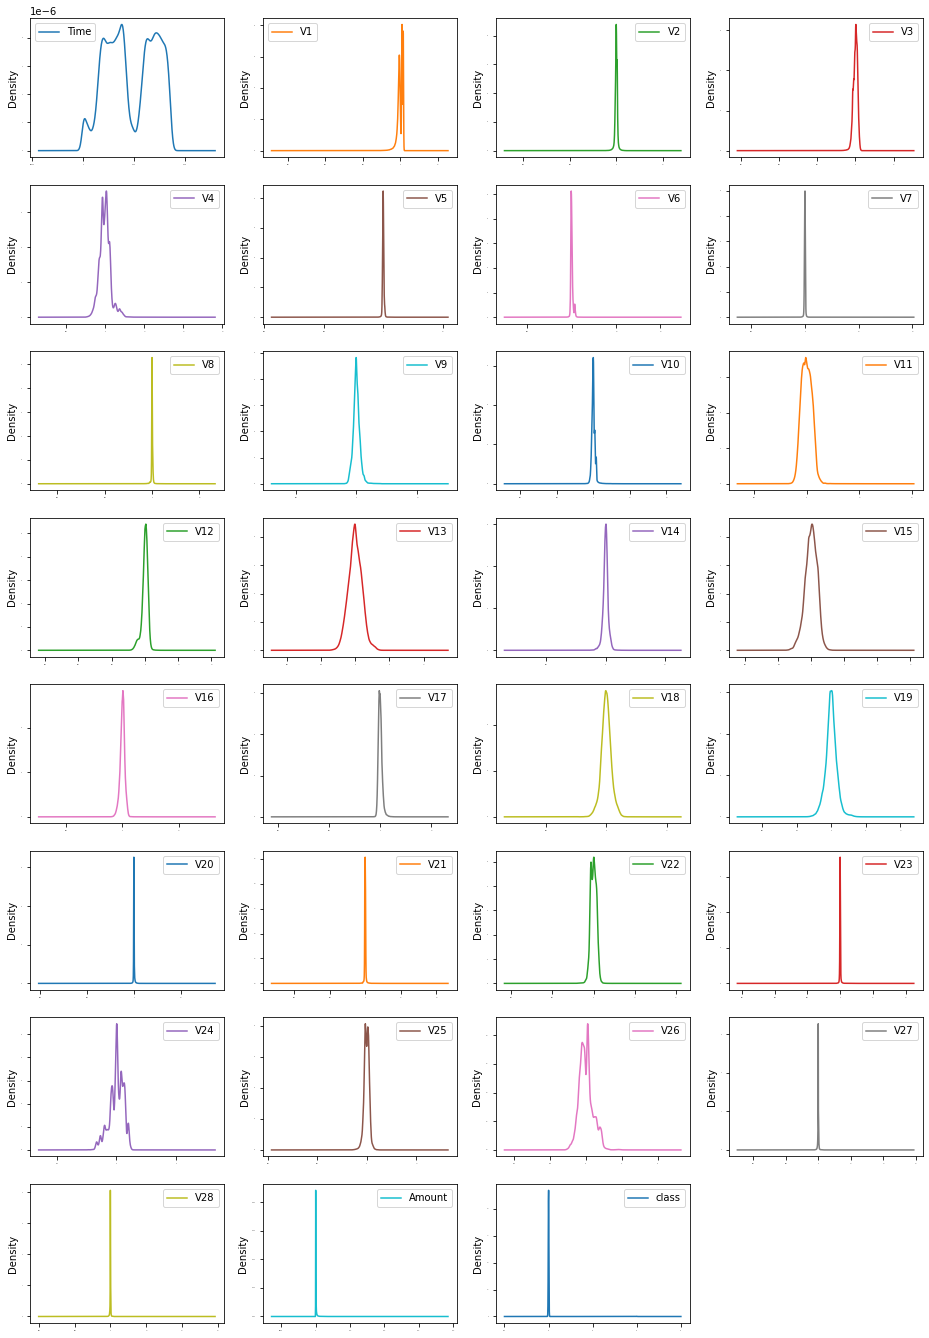

In [ ]:
# plot the distribution of all features
detection.plot(kind='density', subplots=True, layout=(8,4), sharex=False, legend=True, 
                                            fontsize=1, figsize=(16,24))
plt.show()

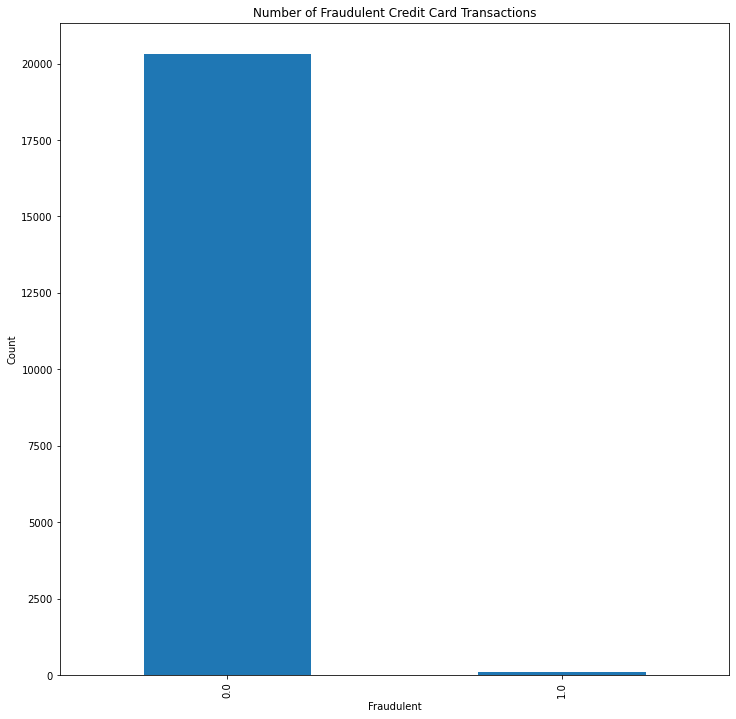

In [3]:
# See distribution of target class
detection['class'].value_counts().plot.bar(figsize=(12,12), xlabel='Fraudulent', ylabel='Count', title='Number of Fraudulent Credit Card Transactions')
plt.show()


In [ ]:
detection.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
class     1
dtype: int64

In [3]:
# Drop null values
detection = detection.dropna()

## Train/Test Split

I used a 70/30 train/test split.

In [4]:
# Perform train/test split
target_col = 'class'
random_seed = 1234

X_train, X_test, y_train, y_test = train_test_split(detection.drop(columns=target_col), detection[target_col],
                                                    test_size=0.3, random_state=random_seed, stratify=detection[target_col])

In [5]:
# Check dimensions of X
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (199364, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
239375,150077.0,-3.161772,-2.304336,1.549989,3.683447,2.329421,-0.839534,0.038500,-0.264317,-0.533572,...,-1.472897,-0.204600,1.437508,2.524874,0.039523,-0.345749,-0.041902,0.586813,-0.424570,1.00
269964,163863.0,-0.381850,0.303814,-0.260084,-2.060956,1.214580,-0.549916,1.185789,-0.229375,-2.055704,...,-0.464700,-0.153063,-0.027070,-0.359650,0.397187,0.427814,0.701023,-0.007525,0.097760,23.90
202400,134313.0,-0.268462,0.943091,-1.913047,-0.714429,3.247672,3.441671,0.752988,0.916438,-0.604810,...,-0.246903,0.118490,0.386412,-0.175112,0.698903,0.250788,-0.583414,-0.334843,-0.270419,28.16
247498,153595.0,-0.431498,0.254134,1.459409,0.203523,-0.192798,0.372215,0.676417,0.014669,-1.213470,...,-0.290083,-0.644777,-1.214616,-0.013649,1.031153,0.796440,-0.665799,-0.005019,-0.033875,80.33
44749,42069.0,1.337094,0.410927,-0.816182,0.588511,0.973178,0.135806,0.460605,-0.129970,-0.499897,...,-0.034724,-0.047018,-0.101805,-0.386261,-1.363426,1.067152,-0.209514,-0.012479,-0.013912,11.46



On X test: 
X test dimensions:  (85443, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
34772,37818.0,-1.175792,0.730922,2.161038,1.785405,-0.747073,0.610056,-0.226681,0.774999,0.271984,...,0.209729,-0.260243,-0.381259,0.092140,0.419344,-0.028434,-0.393868,0.316644,0.095543,48.37
40849,40427.0,-1.137628,0.820015,0.534871,0.909786,0.261743,-0.824944,0.081064,0.392912,-0.349883,...,-0.023262,0.125876,0.215380,-0.263854,-0.162596,-0.182965,-0.294255,0.186506,0.082927,4.64
236600,148876.0,1.903698,-0.499607,-0.417471,0.410356,-0.457666,0.176311,-0.719528,0.164885,0.839337,...,-0.107917,0.323845,1.033948,0.120948,0.767959,-0.208740,0.407666,-0.018655,-0.045125,31.07
69139,53286.0,1.501556,-0.737981,-0.038703,-1.414446,-1.054984,-1.113152,-0.454810,-0.361994,-2.666622,...,-0.254655,-0.091813,0.160982,-0.084928,0.581525,0.667082,-0.118058,0.001451,0.001522,15.00
35113,37969.0,1.255179,0.415270,0.323419,0.685721,-0.294305,-1.052138,0.147617,-0.254034,-0.100733,...,-0.022597,-0.276938,-0.758367,0.118027,0.369485,0.245484,0.091361,-0.017497,0.032870,2.69


In [6]:
# Check dimensions of Y
# Y Train
print('On Y train: ')
print('Y train dimensions: ', y_train.shape)
display(y_train.head())

# Y test
print('\nOn Y test: ')
print('Y test dimensions: ', y_test.shape)
display(y_test.head())

On Y train: 
Y train dimensions:  (199364,)


239375    0
269964    0
202400    0
247498    0
44749     0
Name: class, dtype: int64


On Y test: 
Y test dimensions:  (85443,)


34772     0
40849     0
236600    0
69139     0
35113     0
Name: class, dtype: int64

## Pipeline


### Logistic Regression

I'm using a `StandardScaler()` and `SimpleImputer()` to deal with the numerical values in the my pipeline.

In [7]:
# Build pipeline for building numerical data

num_pipeline = Pipeline(steps=[('scale_num', StandardScaler()),
                                ('num_imputer', SimpleImputer(missing_values=np.nan, strategy="mean"))])
preproc_pipe = ColumnTransformer([('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                                 remainder='passthrough')

In [8]:
# Build model pipeline
logistic_regression_pipe = Pipeline(steps=[('Preprocessing', num_pipeline),
                                           ('Model', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

# View Pipeline
with config_context(display='diagram'):
    display(logistic_regression_pipe)

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('scale_num', StandardScaler()),
                                 ('num_imputer', SimpleImputer())])),
                ('Model',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

## Model Fit & Evaluation

### Logistic Regression Fit & Evaluation

`GridSearchCV()` is used for hyperparameter tuning.

In [9]:
# Setup Tuning Grid & Grid Search for Logistic Regression with and without Feature Engineering

logistic_regression_tuning_grid = {'Model__l1_ratio': np.linspace(0,1,5),
                                   'Model__C': np.logspace(-1,6,3)}

logistic_regression_grid_search = GridSearchCV(logistic_regression_pipe, param_grid=logistic_regression_tuning_grid, return_train_score=True, n_jobs=-1)

In [10]:
# Perform Hyperparameter tuning using Grid Search
logistic_regression_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('Preprocessing',
                                        Pipeline(steps=[('scale_num',
                                                         StandardScaler()),
                                                        ('num_imputer',
                                                         SimpleImputer())])),
                                       ('Model',
                                        LogisticRegression(penalty='elasticnet',
                                                           solver='saga',
                                                           tol=0.01))]),
             n_jobs=-1,
             param_grid={'Model__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06]),
                         'Model__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             return_train_score=True)

In [11]:
# logistic regression best model parameteres and values
print(logistic_regression_grid_search.best_score_)
print(logistic_regression_grid_search.best_params_)

0.9991472882511523
{'Model__C': 1000000.0, 'Model__l1_ratio': 0.5}


In [12]:
# logistic regression best estimator pipeline
logistic_regression_grid_search.best_estimator_

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('scale_num', StandardScaler()),
                                 ('num_imputer', SimpleImputer())])),
                ('Model',
                 LogisticRegression(C=1000000.0, l1_ratio=0.5,
                                    penalty='elasticnet', solver='saga',
                                    tol=0.01))])

## Performance Metrics

Confusion matrices are created for the standard predictions and the predictions with the altered threshold calculated from the ROC curve.

In [14]:
# Classification Report for logistic regression model
print(classification_report(y_test, logistic_regression_grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.65      0.74       148

    accuracy                           1.00     85443
   macro avg       0.93      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



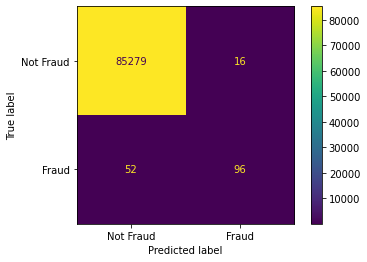

In [15]:
# Confusion Matrix for logistic regression model

lr_cm = confusion_matrix(y_test, logistic_regression_grid_search.best_estimator_.predict(X_test))
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,
                                    display_labels=['Not Fraud', 'Fraud'])
lr_disp.plot()
plt.show()

### ROC Curve

Best Threshold=0.007888, G-Mean=0.961


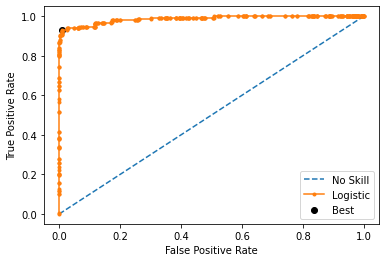

In [16]:
from numpy import sqrt
from numpy import argmax

# ROC curve for logistic regression model with optimal threshold

# predict probabilities
yhat = logistic_regression_grid_search.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [17]:
# Classificiation Report with predictions using optimal threshold

threshold = thresholds[ix]
y_pred = (logistic_regression_grid_search.best_estimator_.predict_proba(X_test)[:, 1] > threshold).astype('float')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.15      0.93      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.96      0.62     85443
weighted avg       1.00      0.99      0.99     85443



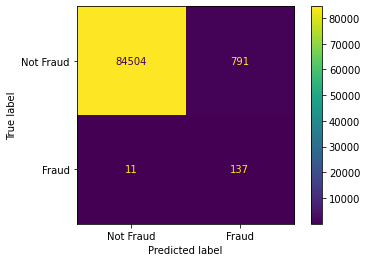

In [18]:
# Confusion Matrix for logistic regression model after using optimal threshold

lr_cm_thresh = confusion_matrix(y_test, y_pred)
lr_thresh_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm_thresh,
                                    display_labels=['Not Fraud', 'Fraud'])
lr_thresh_disp.plot()
plt.show()

### Potential Business Metrics

For practice purposes, let's make some monetary assumptions about all cases in the confusion matrix. This will be a division of a bank whose clients are high net worth individuals.

- True Positive: True label = Not Fraud & Predicted label = Not Fraud
    - In this instance we've predicted a transaction to not be fraudulent and its true label is not fraudulent which results in no cost.

- False Positive: True label = Not Fraud & Predicted label = Fraud
    - In this instance we've predicted a transaction to be fraudulent but it turns out that it isn't.
    - The cost here is the refunding of a transaction when not needed. Since the average fraudulent transaction is $300, that'll be the cost per transaction.
        - $300(t) = COST

- False Negative: True label = Fraud & Predicted label = Not Fraud
    - In this instance we've predicted a transaction to not be fraudulent but it turns out that it is fraudulent.
    - The cost here is the customer having to call customer service to report a fraudulent transaction which leads to a loss of customer every 10 transactions. This is estimated to cost $100K on average by losing on transaction fees from millions of dollars of purchases per customer. The fraudulent charges are still refunded so we'll use the same formula as above for that portion of the equation.
        - t/10(100,000) + 300(t) = COST
 
- True Negative: True label = Fraud & Predicted label = Fraud
    - In this instance we've predicted a transaction to be fraudulent and its true label is fraudulent which results in no cost.

In [40]:
# Logistic Regression Business Costs

lr_true_non = 0
lr_false_non = (300*(lr_cm[0][1]))
lr_false_fraud = ((lr_cm[1][0] // 10)*(100000)) + (300*(lr_cm[1][0]))
lr_true_fraud = 0

lr_total_cost = (lr_true_non + lr_false_non + lr_false_fraud + lr_true_fraud)

print(f'The total business cost using a logistic regression model is ${lr_total_cost}')

The total business cost using a logistic regression model is $520400


In [41]:
# Logistic Regression with Threshold Business Costs

lrt_true_non = 0
lrt_false_non = (300*(lr_cm_thresh[0][1]))
lrt_false_fraud = ((lr_cm_thresh[1][0] // 10)*(100000)) + (300*(lr_cm_thresh[1][0]))
lrt_true_fraud = 0

lrt_total_cost = (lrt_true_non + lrt_false_non + lrt_false_fraud + lrt_true_fraud)

print(f'The total business cost using a logistic regression model using the ROC threshold is ${lrt_total_cost}')

The total business cost using a logistic regression model using the ROC threshold is $340600


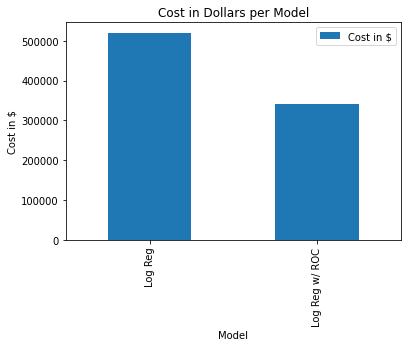

In [47]:
# Bar plot of cost comparisons

model_names = ['Log Reg', 'Log Reg w/ ROC']
model_costs = [lr_total_cost, lrt_total_cost]

model_comp = pd.DataFrame({'Model': model_names, 'Cost in $': model_costs})
model_comp.plot.bar(x='Model', ylabel='Cost in $', title='Cost in Dollars per Model')
plt.show()

## Summary

Given the high cost of the false negative case, using the threshold calculated from the ROC curve saved almost $200K. As we see in the confusion matrices, using the probability threshold to predict values from the test set greatly increases our recall but as a result decreases precision. In my opinion, when your false negative case is extremely costly, it is very beneficial to use the calculated probability threshold. An example of this would be predicting COVID test results. The false negative in this scenario would be predicting a result to be negative for COVID but the true result being positive for COVID. This would be extremely costly to public health outcomes. When the cost of the false negative and false positive cases are about the same, I would advise against using this method and maybe looking at resampling your dataset to make it more balanced. Again, this notebook was created to show the pros and cons of using an ROC curve to calculate a probability threshold with unbalanced datasets in binary classification. It is recommended that a combination of different methods are used to deal with unbalanced datasets!